In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import anndata
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.size"] = 10

In [2]:
adata = anndata.read_h5ad("C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden_res0_6', 'manual_celltype_annotation', 'celltypist_cell_label', 'celltypist_conf_score', 'celltypist_cell_label_coarse'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_colors', 'hvg', 'leiden', 'leiden_res0_6_colors', 'neighbors', 'pca', 'sampleID_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'int_norm', 'log_int_norm', 'log_norm', 'norm', 'raw'
    obsp: 'connectivitie

In [3]:
# set your gene of interest (GOI) here:

GOI = "CASP8"

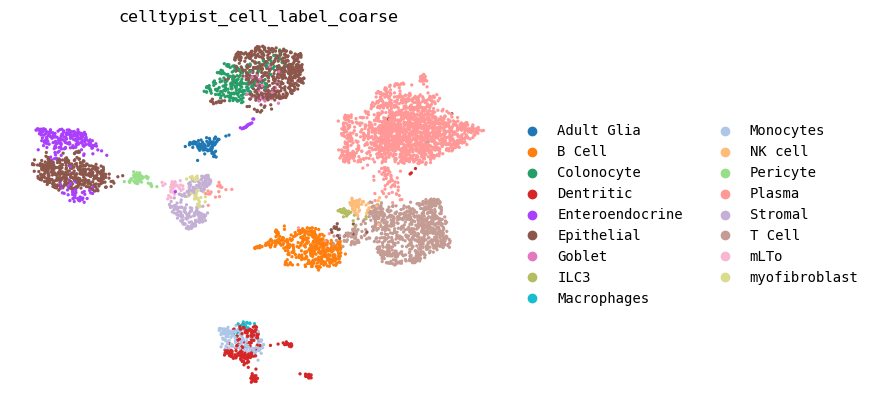

In [4]:
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_coarse"],
    frameon=False,
)

In [5]:
def clean_data(df, col, threshold = 99.75):
    data = df[col].to_numpy().flatten()
    data = data[data <= np.percentile(data, threshold)]
    return data

def find_thresholds(filtered):
    range = (abs(max(filtered)) + abs(min(filtered)))
    step = range / float(4)
    very_low = min(filtered) + step
    low = min(filtered) + step*2
    middle = min(filtered) + step*3
    #print(round(very_low, 2), round(low, 2), round(middle, 2), round(max(filtered), 2))
    return very_low, low, middle, max(filtered)

def classify_exp_level(df, filtered, col):
    very_low, low, middle, high = find_thresholds(filtered)
    def func(x):
        if x <= very_low:
            return "very_low"
        elif very_low < x <= low:
            return "low"
        elif low < x <= middle:
            return "middle"
        elif middle < x <= high:
            return "high"
        else:
            return "very_high"
    df['expr_class'] = df[col].apply(func)
    return df

def make_df(adata, col):
    sc.pp.highly_variable_genes(adata, layer='log_norm')
    df = adata.var.sort_values(['means'])
    df['gene_num'] = range(len(df))
    df['log(means)'] = np.log(df['means'])
    df['log1p(means)'] = np.log1p(df['means'])

    filtered = clean_data(df, col=col, threshold=99.75) # can choose upper outlier threshold here
    df_new = classify_exp_level(df =df, filtered=filtered, col=col)
    return df_new

In [6]:
def explain_expr_celltypes(adata, col):
    print(GOI + " Expression across cell types: ")
    print("\t [cell type]; [expression classification]; [avg. expression over this cell type]")
    for cell_type in adata.obs['celltypist_cell_label_coarse'].unique():
        subset = adata[adata.obs['celltypist_cell_label_coarse'] == cell_type]
        df = make_df(subset, col)
        print("\t " + cell_type + ";  " + str(df.loc[df.index == GOI]['expr_class'].values[0]) + ";  " + str(round(df.loc[df.index == GOI][col].values[0], 3)))


In [7]:
explain_expr_celltypes(adata, 'log1p(means)')

CASP8 Expression across cell types: 
	 [cell type]; [expression classification]; [avg. expression over this cell type]
	 mLTo;  very_low;  0.034
	 Monocytes;  very_low;  0.171
	 B Cell;  very_low;  0.221
	 Epithelial;  very_low;  0.135
	 T Cell;  low;  0.399
	 Dentritic;  very_low;  0.162
	 Plasma;  very_low;  0.184
	 Enteroendocrine;  very_low;  0.163
	 Colonocyte;  very_low;  0.12
	 myofibroblast;  very_low;  0.141
	 Stromal;  very_low;  0.12
	 Adult Glia;  very_low;  0.027
	 Pericyte;  very_low;  0.054
	 ILC3;  very_low;  0.266
	 NK cell;  very_low;  0.357
	 Macrophages;  very_low;  0.269
	 Goblet;  very_low;  0.246


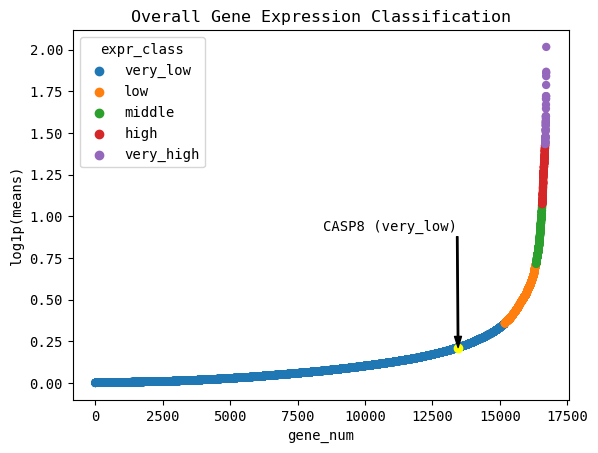

In [8]:
# find overall expression of all genes, highlighting GOI
col = 'log1p(means)' 
df_new = make_df(adata, col)

g = sns.scatterplot(data=df_new, x='gene_num',  y=col, hue='expr_class', linewidth=0)
annotation = str(GOI + " (" + df_new.loc[df_new.index == GOI]['expr_class'].values[0] + ")")
highlight_y = df_new.loc[df_new.index == GOI][col]
highlight_x = df_new.loc[df_new.index == GOI]['gene_num']
g.scatter(highlight_x, highlight_y, color = 'yellow', linewidth=1)
props = dict(facecolor='black', width=1, headwidth=5, headlength=8)
g.annotate(annotation, (highlight_x, highlight_y), (highlight_x-5000, highlight_y+0.7), arrowprops=props)
g.set_title(str("Overall Gene Expression Classification"))
plt.show()

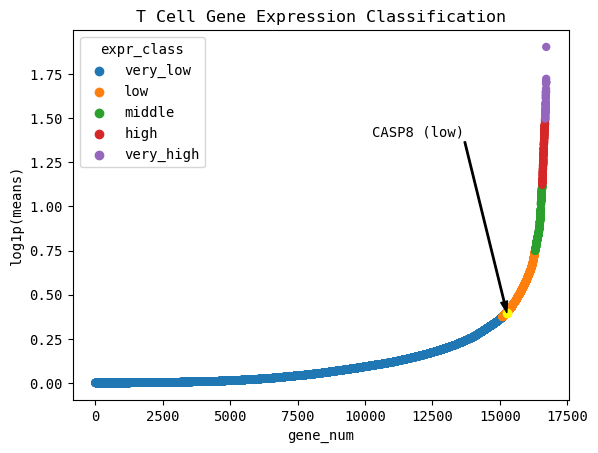

In [9]:
# find overall expression of all genes within cell type of interest, highlighting GOI

cell_type = 'T Cell' #TODO: find this automatically?  
adata_sub = adata[adata.obs['celltypist_cell_label_coarse'] == cell_type]

col = 'log1p(means)' 
df_new = make_df(adata_sub, col)

g = sns.scatterplot(data=df_new, x='gene_num',  y=col, hue='expr_class', linewidth=0)
annotation = str(GOI + " (" + df_new.loc[df_new.index == GOI]['expr_class'].values[0] + ")")
highlight_y = df_new.loc[df_new.index == GOI][col]
highlight_x = df_new.loc[df_new.index == GOI]['gene_num']
g.scatter(highlight_x, highlight_y, color = 'yellow', linewidth=1)
props = dict(facecolor='black', width=1, headwidth=5, headlength=8)
g.annotate(annotation, (highlight_x, highlight_y), (highlight_x-5000, highlight_y+1), arrowprops=props)
g.set_title(str(cell_type + " Gene Expression Classification"))
plt.show()

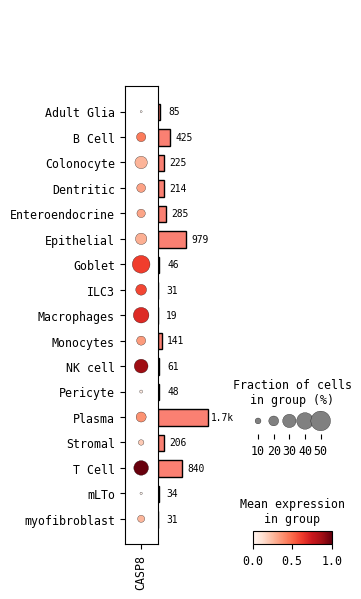

In [10]:
# find expression across cell types of GOI here
markers=[GOI]
ax1 = sc.pl.dotplot(adata, var_names=markers, groupby='celltypist_cell_label_coarse', return_fig=True, standard_scale='var')
ax1.add_totals().show()

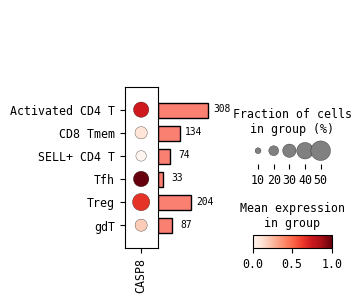

In [11]:
# TODO: zoom in AUTOMATICALLY on sub-cell types in cell type(s) where GOI is differentially expressed 
cell_type = 'T Cell'

ax1 = sc.pl.dotplot(adata[adata.obs['celltypist_cell_label_coarse'] == cell_type], var_names=markers, groupby='celltypist_cell_label', return_fig=True, standard_scale='var')
ax1.add_totals().show()

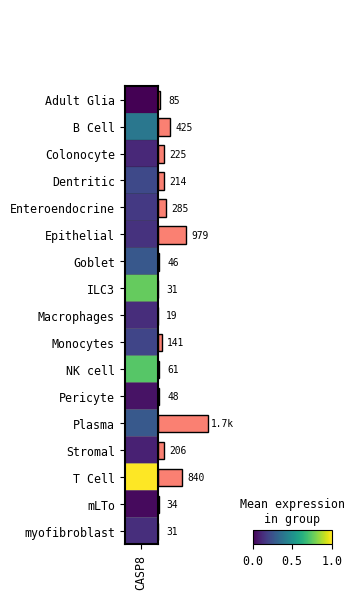

In [12]:
ax2 = sc.pl.matrixplot(adata, markers, groupby='celltypist_cell_label_coarse', return_fig=True, layer='log_int_norm', standard_scale='var')
ax2.add_totals().style(edge_color='black').show()

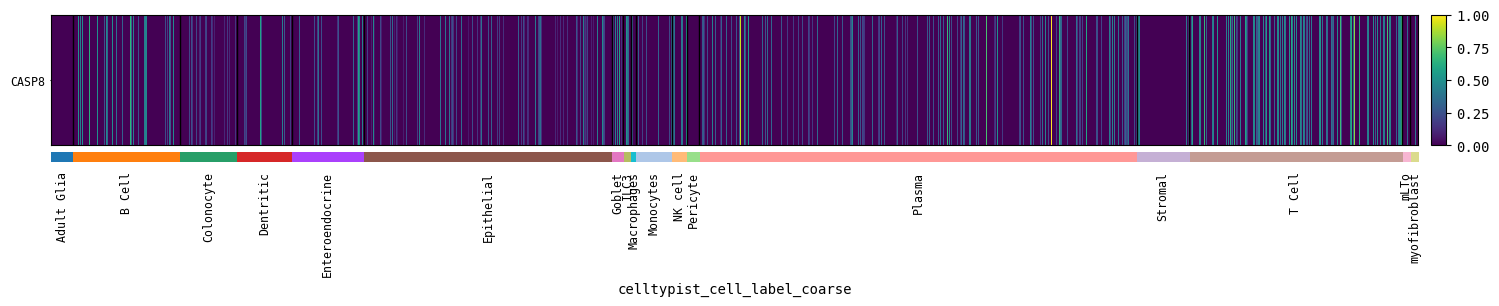

In [13]:
sc.pl.heatmap(adata, markers, groupby='celltypist_cell_label_coarse', swap_axes=True, figsize=(18,2), layer='log_norm', standard_scale='var')

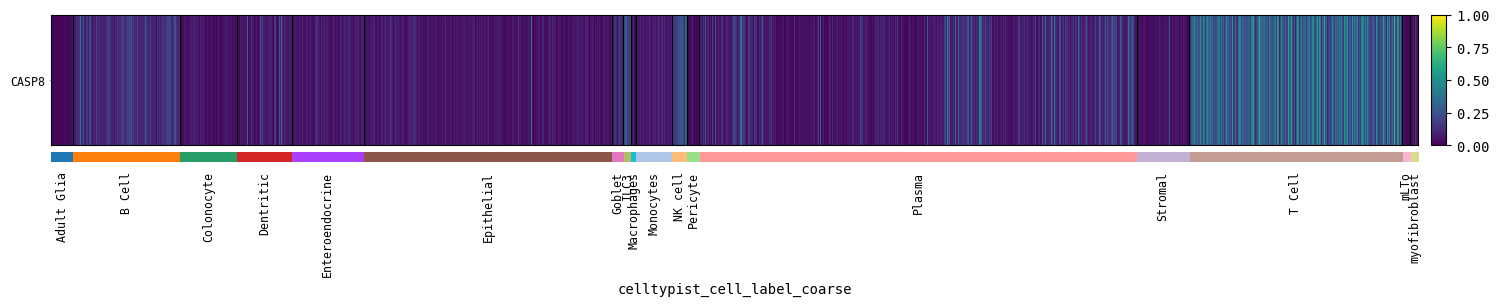

In [14]:
# heatmap with scvi normalized and logged values (sometimes shows a more clear cell type because of smoothing)
sc.pl.heatmap(adata, markers, groupby='celltypist_cell_label_coarse', swap_axes=True, figsize=(18,2), layer='log_int_norm', standard_scale='var')